In [1]:
import pandahouse
import pandas as pd
import numpy as np
import arviz as az

import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования прогноза
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров

In [2]:
connection = {'host': '*',
'database':'*',
'user':'*',
'password':'*'
}


<p>В качестве основной прогнозируемой метрики я взял DAU. Так как каждый пользователь в БД (новостная лента) отражается не просто по присутствию, а по действию (просмотр/лайк). Исследуя вопрос нагрузки на серверы, важно учитывать сколько пользователей совершают действия за определённый промежуток времени. Прямо на этот вопрос отвечает метрика DAU.
<p>Для анализа я возьму весь период существования продукта, так как он небольшой и будет расчитываться вполне быстро.
<p>Единственный регрессор, который планировал взять - event_flag (наличие/отсутствие события). 2024-03-14 - рекламная кампания, 2024-03-23 - падение из-за сбоя. Однако, метод make_future_df выдаёт ошибку при работе с этой колонкой. В документации решения не нашел. Поэтому задачу решаю без регрессоров.

In [46]:
q = '''
SELECT toStartOfDay(toDateTime(time)) as time,
       count(distinct user_id) as dau
FROM simulator_20240320.feed_actions
where toDateTime(time) < today()
GROUP BY time
ORDER BY time
'''

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,time,dau
0,2024-02-03,878
1,2024-02-04,2238
2,2024-02-05,3105
3,2024-02-06,3721
4,2024-02-07,4617


In [47]:
dlt = DLT(response_col="dau", #название колонки с метрикой
 date_col="time", #название колонки с датами-временем
 seasonality=7, #длина периода сезонности 
 estimator="stan-mcmc", #алгоритм оценки
 n_bootstrap_draws=1000,
 ) #количество сэмплов бутстрапа для доверительного интервала

In [48]:
dlt.fit(df)

2024-04-13 16:24:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [49]:
future_df = dlt.make_future_df(periods=30) 
#горизонт будет 7 дней

In [50]:
predicted_df = dlt.predict(df=future_df)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

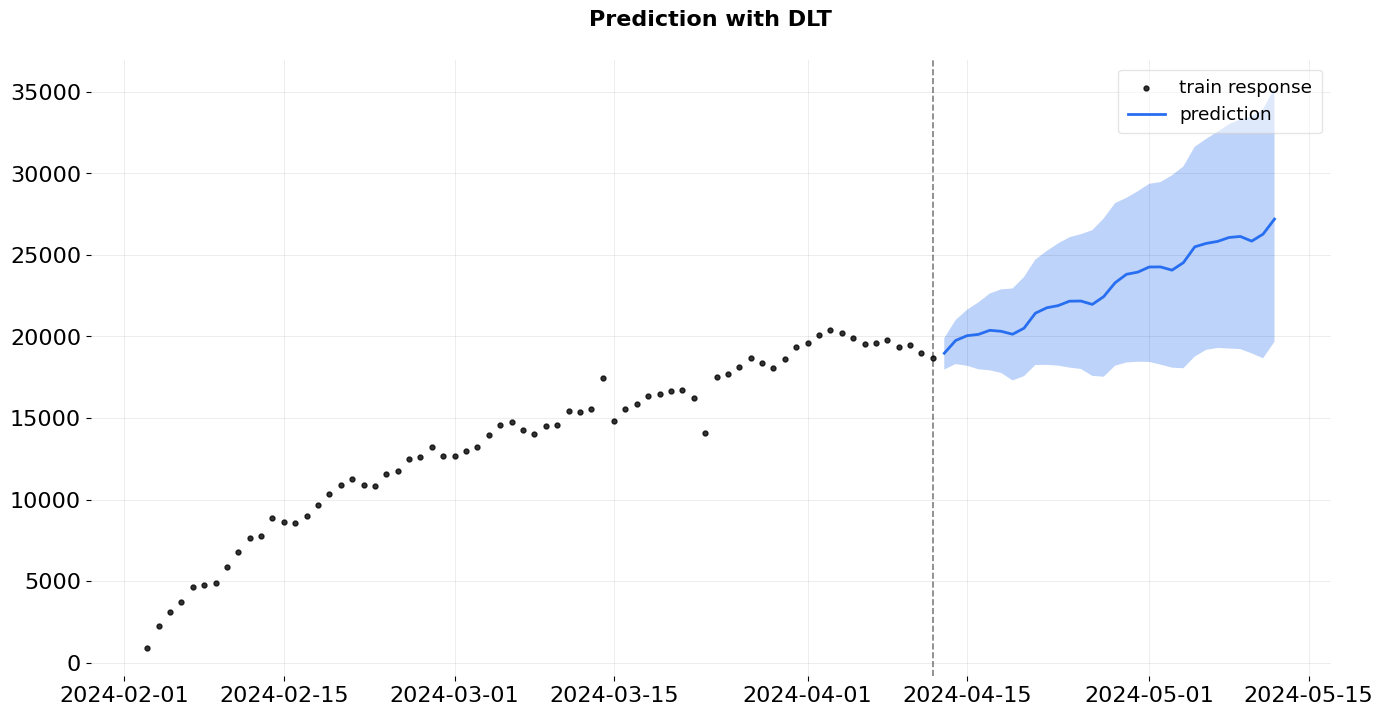

In [51]:
_ = plot_predicted_data(df, #изначальные данные
 predicted_df, #датафрейм с предсказаниями
 "time", #колонка со временем
'dau', #колонка со значениями временного ряда
 title='Prediction with DLT') #заголовок рисунка


In [52]:
params = dlt.get_posterior_samples(permute=False) #достаём информацию о параметрах

params.keys() #их названия - можно залезть в оригинальный код на Stan, чтобы вычислить их значение

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

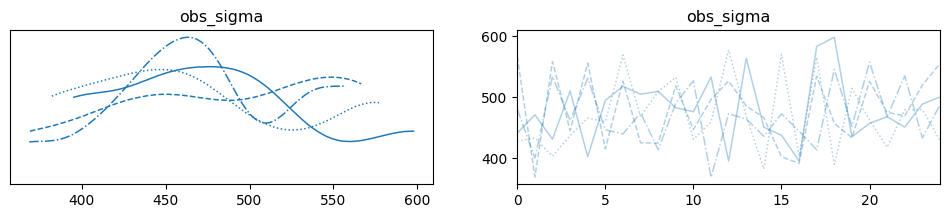

In [53]:
az.plot_trace(params, #словарь с параметрами
              var_names = 'obs_sigma') #названия параметров, на которые мы смотрим

Затрудняюсь интерпретировать график. На мой неопытный взгляд - <b>они сходятся</b>.

In [54]:
bt_exp = BackTester(
 model = dlt, #наша моделька
 df = df, #датафрейм для обучения
 min_train_len = 7, #самый маленький кусочек данных, с которого начинается обучение
 incremental_len = 7, #на сколько происходит прирост тренировочных данных
 forecast_len = 7, #горизонт прогнозирования
 window_type = 'rolling' #тип окошка
)

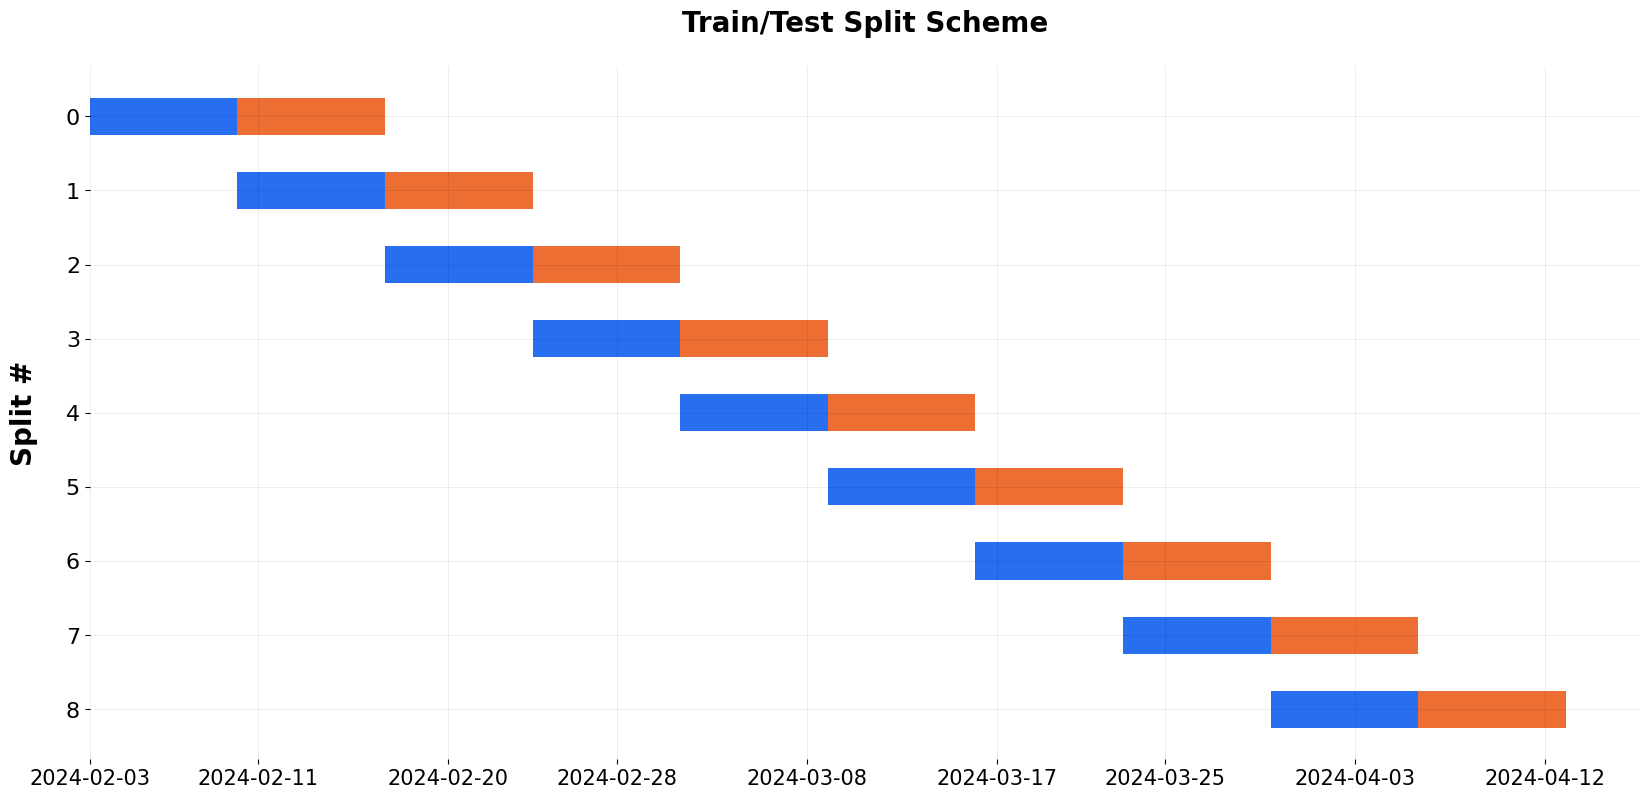

In [55]:
bt_exp.plot_scheme()

In [56]:
bt_exp.fit_predict() #обучаем

2024-04-13 16:25:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2024-04-13 16:25:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [57]:
bt_exp.score()

,metric_name,metric_values,is_training_metric
0,smape,6.470944e-02,False
1,wmape,6.072347e-02,False
2,mape,6.264085e-02,False
3,mse,1.170116e+06,False
4,mae,8.954698e+02,False
5,rmsse,1.354068e+00,False


<p>Для исследования выбрана модель DLT с марковскими цепями. Модель была провалидирована бэктестингом. Результаты оценки можно видеть выше. 
<p>SMAPE, WMAPE, MAPE - метрики связанные с процентной ошибкой, примерно равны 6%, что при небольшом наборе данных вполне неплохой результат. MAE - средняя абсолютная ошибка равна 895, при DAU в 15-20 тысяч - результат удовлетворительный. 
<p>Модель имеет относительно низкие значения ошибок, что говорит о том, что она хорошо справляется с прогнозированием данных. Согласно её прогнозу, через месяц дневная аудитория будет в диапазоне от 20 тысяч до 35 тысяч, с трендом в 26,5 тысячи. При худшем прогнозе аудитория останется такой же, но с большей вероятностью она увеличится на 25-50%.